In [1]:
# Import libraries
import psycopg2
import getpass
import time
import matplotlib.pyplot as plt
import numpy as np
import os.path
from sklearn.model_selection import train_test_split

In [2]:
# Define feature file names
feature_files = ['admission_type', 'age', 'aids_haem_mets', 'bicarb', 'bilirubin', 'blood_pressure', 'fio2', \
                 'gcs_eyes', 'gcs_motor', 'gcs_verbal', 'heart_rate', 'pao2', 'potassium', 'sodium', 'temperature', 'urea', 'urine', 'wbc']

# Define processed feature names
feature_names = ['admission_type', 'age', 'aids_haem_mets', 'bicarb_48h', 'bilirubin_48h', 'bp_48h', 'fio2_48h', \
                 'gcs_eyes_48h', 'gcs_motor_48h', 'gcs_verbal_48h', 'hr_48h', 'pao2_48h', 'potassium_48h', 'sodium_48h', 'temp_48h', 'urea_48h', 'urine_48h', 'wbc_48h']

In [3]:
# Load the data
start = time.time()
for i in range(len(feature_files)):
    _data = np.load('res/{}.npy'.format(feature_files[i]), allow_pickle=True).tolist()
    exec("{} = _data['{}']".format(feature_names[i], feature_names[i]))
end = time.time()
print("All files loaded!")
print("This took {} minutes".format(round((end-start)/60,2)))

All files loaded!
This took 1.71 minutes


In [4]:
# Check shape of files
for i in range(len(feature_files)):
    print("{}: ".format(feature_names[i]))
    exec("shape = np.shape({})\nprint(shape)".format(feature_names[i]))
    print("")

admission_type: 
(38549, 4)

age: 
(38549, 2)

aids_haem_mets: 
(38549, 4)

bicarb_48h: 
(38549, 49, 1)

bilirubin_48h: 
(38549, 49, 1)

bp_48h: 
(38549, 49, 1)

fio2_48h: 
(38549, 49, 1)

gcs_eyes_48h: 
(38549, 49, 1)

gcs_motor_48h: 
(38549, 49, 1)

gcs_verbal_48h: 
(38549, 49, 1)

hr_48h: 
(38549, 49, 1)

pao2_48h: 
(38549, 49, 1)

potassium_48h: 
(38549, 49, 1)

sodium_48h: 
(38549, 49, 1)

temp_48h: 
(38549, 49, 1)

urea_48h: 
(38549, 49, 1)

urine_48h: 
(38549, 49, 1)

wbc_48h: 
(38549, 49, 1)



In [5]:
# Broadcast static features so they have 24 time steps
sched_surg_48h = np.column_stack((admission_type[:,0], np.tile(admission_type[:,1], (48,1)).T))
unsched_surg_48h = np.column_stack((admission_type[:,0], np.tile(admission_type[:,2], (48,1)).T))
medical_48h = np.column_stack((admission_type[:,0], np.tile(admission_type[:,3], (48,1)).T))
age_48h = np.column_stack((age[:,0], np.tile(age[:,1], (48,1)).T))
aids_48h = np.column_stack((aids_haem_mets[:,0], np.tile(aids_haem_mets[:,1], (48,1)).T))
haem_48h = np.column_stack((aids_haem_mets[:,0], np.tile(aids_haem_mets[:,2], (48,1)).T))
mets_48h = np.column_stack((aids_haem_mets[:,0], np.tile(aids_haem_mets[:,3], (48,1)).T))

# Check the dimensions are correct
print("sched_surg_48h: ", np.shape(sched_surg_48h))
print("unsched_surg_48h: ", np.shape(unsched_surg_48h))
print("medical_48h: ", np.shape(medical_48h))
print("age_48h: ", np.shape(age_48h))
print("aids_48h: ", np.shape(aids_48h))
print("haem_48h: ", np.shape(haem_48h))
print("mets_48h: ", np.shape(mets_48h))

sched_surg_48h:  (38549, 49)
unsched_surg_48h:  (38549, 49)
medical_48h:  (38549, 49)
age_48h:  (38549, 49)
aids_48h:  (38549, 49)
haem_48h:  (38549, 49)
mets_48h:  (38549, 49)


In [6]:
# Stack all features into one array
dataset = np.dstack((sched_surg_48h, unsched_surg_48h, medical_48h, age_48h, aids_48h, haem_48h, mets_48h, bicarb_48h, bilirubin_48h, bp_48h, \
                     fio2_48h, gcs_eyes_48h, gcs_motor_48h, gcs_verbal_48h, hr_48h, pao2_48h, potassium_48h, sodium_48h, temp_48h, urea_48h, urine_48h, wbc_48h))

# Remove the patient IDs
dataset = dataset[:,1:,:]

# Transpose dataset so it is in the shape (m,n,T)
dataset = np.transpose(dataset, (0,2,1))

# Check the shape of the dataset
print("dataset: ", np.shape(dataset))

dataset:  (38549, 22, 48)


In [7]:
# Check the data to make sure there's nothing too crazy going on
feat_names = ["sched_surg_48h", "unsched_surg_48h", "medical_48h", "age_48h", "aids_48h", "haem_48h", "mets_48h", "bicarb_48h", "bilirubin_48h", "bp_48h", \
              "fio2_48h", "gcs_eyes_48h", "gcs_motor_48h", "gcs_verbal_48h", "hr_48h", "pao2_48h", "potassium_48h", "sodium_48h", "temp_48h", "urea_48h", "urine_48h", "wbc_48h"]

n = len(feat_names)
for i in range(n):
    feature = dataset[:,i,:]
    print("{}:".format(feat_names[i]))
    print("Min = {}; Max = {}; Mean = {}; Standard Deviation = {}".format(round(np.min(feature),2), round(np.max(feature),2), round(np.mean(feature),2), round(np.std(feature),2)))
    print("")

sched_surg_48h:
Min = 0.0; Max = 1.0; Mean = 0.14; Standard Deviation = 0.35

unsched_surg_48h:
Min = 0.0; Max = 1.0; Mean = 0.28; Standard Deviation = 0.45

medical_48h:
Min = 0.0; Max = 1.0; Mean = 0.72; Standard Deviation = 0.45

age_48h:
Min = 18.0; Max = 300.0; Mean = 74.63; Standard Deviation = 55.08

aids_48h:
Min = 0.0; Max = 1.0; Mean = 0.01; Standard Deviation = 0.09

haem_48h:
Min = 0.0; Max = 1.0; Mean = 0.03; Standard Deviation = 0.16

mets_48h:
Min = 0.0; Max = 1.0; Mean = 0.06; Standard Deviation = 0.24

bicarb_48h:
Min = 0.0; Max = 53.0; Mean = 24.08; Standard Deviation = 5.33

bilirubin_48h:
Min = 0.0; Max = 82.8; Mean = 0.86; Standard Deviation = 2.67

bp_48h:
Min = 0.0; Max = 119119.02; Mean = 117.59; Standard Deviation = 113.78

fio2_48h:
Min = 0.0; Max = 100.0; Mean = 23.67; Standard Deviation = 34.62

gcs_eyes_48h:
Min = 0.0; Max = 4.0; Mean = 3.17; Standard Deviation = 1.25

gcs_motor_48h:
Min = 0.0; Max = 6.0; Mean = 5.02; Standard Deviation = 1.86

gcs_verbal_4

In [8]:
# As seen above, some features have values below zero and need to be clipped
clipped_dataset = np.clip(dataset, 0, a_max=None)

In [9]:
# Load the mortality data
_data = np.load('res/mortality.npy', allow_pickle=True).tolist()
mortality = _data['mortality']

# Remove the patient IDs
mortality = mortality[:,1]

# Check the shape of the mortality
print("mortality: ", np.shape(mortality))

mortality:  (38549,)


In [10]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(clipped_dataset, mortality, train_size=0.8, random_state=42)

# Split the test data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, random_state=42)

# Check the shapes of the outputs
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (30839, 22, 48)
y_train: (30839,)
X_val: (3855, 22, 48)
y_val: (3855,)
X_test: (3855, 22, 48)
y_test: (3855,)


In [11]:
# Print information about the created arrays
print("No. of patients: {}".format(len(dataset)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of patients who died in hospital in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of patients who died in hospital in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 38549
No. of patients in train, val, test sets: 30839, 3855, 3855
No. of patients who died in hospital in train, val, test sets: 3458.0, 417.0, 445.0
Proportion of patients who died in hospital in train, val, test sets: 11.213%, 10.817%, 11.543%


In [12]:
# Write a function to normalises the data using the MinMaxScaler, treating each feature separately
def MinMaxScaler_3D(array, minimum=None, maximum=None):
    
    '''
    INPUTS:
    array - a 3D array of shape (m, n, T), where m = number of examples, n = number of features, and T = number of time steps.
    minimum (optional) - the minimum you want to apply for the scaling. If not specified, the minimum will be calculated from the array.
    maximum (optional) - the maximum you want to apply for the scaling. If not specified, the maximum will be calculated from the array.
    -> note that minimum and maximum, if specified, need to be n-length vectors, where each entry represents the min/max for each feature in the array.
    
    OUTPUTS:
    scaled_array - a 3D array where each entry in array has been scaled using the equation y = (x - min) / (max - min), and the min/max has been calculated individually for each feature.
    min_vector (optional) - an n-length vector where each entry is the minimum for each feature. Only returned if minimum is not specified.
    max_vector (optional) - an n-length vector where each entry is the maximum for each feature. Only returned if maximum is not specified.
    '''
    
    # First, get the dimensions of the input array
    m, n, T = np.shape(array)
    
    # Calculate the mininimum of each feature
    if minimum == None:
        min_vector = []
        for i in range(n):
            min_vector.append(np.min(array[:,i,:]))
        no_minmax = True # used for deciding whether to output the min_vector at the end
    else:
        min_vector = minimum
        no_minmax = False
    
    # Calculate the maximum of each feature
    if maximum == None:
        max_vector = []
        for i in range(n):
            max_vector.append(np.max(array[:,i,:]))
    else:
        max_vector = maximum
        
    # Scale each feature using the formula: y = (x - min) / (max - min)
    scaled_array = np.zeros((m,n,T))
    for i in range(n):
        scaled_array[:,i,:] = (array[:,i,:] - min_vector[i]) / (max_vector[i] - min_vector[i])
    
    # Return the outputs
    if no_minmax == True:
        return scaled_array, min_vector, max_vector
    else:
        return scaled_array

In [13]:
# Write a function to normalises the data using the z-score, treating each feature separately
def ZScoreScaler_3D(array, mean=None, std=None):
    
    '''
    INPUTS:
    array - a 3D array of shape (m, n, T), where m = number of examples, n = number of features, and T = number of time steps.
    mean (optional) - the mean you want to apply for the scaling. If not specified, the mean will be calculated from the array.
    std (optional) - the standard deviation you want to apply for the scaling. If not specified, the standard deviation will be calculated from the array.
    -> note that minimum and maximum, if specified, need to be n-length vectors, where each entry represents the min/max for each feature in the array.
    
    OUTPUTS:
    scaled_array - a 3D array where each entry in array has been scaled using the equation y = (x - mean) / std, and the mean/standard deviation has been calculated individually for each feature.
    mean_vector (optional) - an n-length vector where each entry is the mean for each feature. Only returned if mean is not specified.
    std_vector (optional) - an n-length vector where each entry is the standard deviation for each feature. Only returned if std is not specified.
    '''
    
    # First, get the dimensions of the input array
    m, n, T = np.shape(array)
    
    # Calculate the mean of each feature
    if mean == None:
        mean_vector = []
        for i in range(n):
            mean_vector.append(np.mean(array[:,i,:]))
        no_mean_std = True # used for deciding whether to output the min_vector at the end
    else:
        mean_vector = mean
        no_mean_std = False
    
    # Calculate the standard deviation of each feature
    if std == None:
        std_vector = []
        for i in range(n):
            std_vector.append(np.std(array[:,i,:]))
    else:
        std_vector = std
        
    # Scale each feature using the formula: y = (x - mean) / std
    scaled_array = np.zeros((m,n,T))
    for i in range(n):
        scaled_array[:,i,:] = (array[:,i,:] - mean_vector[i]) / std_vector[i]
    
    # Return the outputs
    if no_mean_std == True:
        return scaled_array, mean_vector, std_vector
    else:
        return scaled_array

In [14]:
# Scale the training data, and save the scaler
X_train_norm, mean_vector, std_vector = ZScoreScaler_3D(X_train)

# Use the same scaler to scale the validation and test data
X_val_norm = ZScoreScaler_3D(X_val, mean_vector, std_vector)
X_test_norm = ZScoreScaler_3D(X_test, mean_vector, std_vector)

In [15]:
# Return the shapes, minimums and maximums of the scaled arrays just to make sure everything has worked OK
print("X_train_norm:")
print("Shape: {}, minimum = {}, maximum = {}".format(np.shape(X_train_norm), round(np.min(X_train_norm),2), round(np.max(X_train_norm),2)))
print("")
print("X_val_norm:")
print("Shape: {}, minimum = {}, maximum = {}".format(np.shape(X_val_norm), round(np.min(X_val_norm),2), round(np.max(X_val_norm),2)))
print("")
print("X_test_norm:")
print("Shape: {}, minimum = {}, maximum = {}".format(np.shape(X_test_norm), round(np.min(X_test_norm),2), round(np.max(X_test_norm),2)))
print("")

X_train_norm:
Shape: (30839, 22, 48), minimum = -7.35, maximum = 1171.84

X_val_norm:
Shape: (3855, 22, 48), minimum = -7.35, maximum = 100.41

X_test_norm:
Shape: (3855, 22, 48), minimum = -7.35, maximum = 9602.66



In [16]:
# Replicate patients who died in the training set to balance the two classes
X_deaths = X_train_norm[y_train==1]
y_deaths = y_train[y_train==1]
X_train_norm_bal = np.concatenate((X_train_norm, X_deaths, X_deaths, X_deaths, X_deaths, X_deaths, X_deaths))
y_train_bal = np.concatenate((y_train, y_deaths, y_deaths, y_deaths, y_deaths, y_deaths, y_deaths))

# Check the shapes of the outputs
print("X_train_norm_bal: {}".format(np.shape(X_train_norm_bal)))
print("y_train_bal: {}".format(np.shape(y_train_bal)))
print("Proportion of patients who died in hospital in the balanced training set: {}%".format(round(sum(y_train_bal)/len(y_train_bal)*100,3)))

X_train_norm_bal: (51587, 22, 48)
y_train_bal: (51587,)
Proportion of patients who died in hospital in the balanced training set: 46.923%


In [17]:
# Create a separate day 1 dataset
D1_X_train_norm = X_train_norm[:,:,:24]
D1_X_train_norm_bal = X_train_norm_bal[:,:,:24]
D1_X_val_norm = X_val_norm[:,:,:24]
D1_X_test_norm = X_test_norm[:,:,:24]

# Create a separate day 2 dataset
D2_X_train_norm = X_train_norm[:,:,24:]
D2_X_train_norm_bal = X_train_norm_bal[:,:,24:]
D2_X_val_norm = X_val_norm[:,:,24:]
D2_X_test_norm = X_test_norm[:,:,24:]

In [18]:
# Save to data.npy
if not os.path.exists('./res'):
    os.makedirs('./res')

tosave = {'X_train': X_train, 'X_val': X_val, 'X_test': X_test, \
          'X_train_norm': X_train_norm, 'X_train_norm_bal': X_train_norm_bal, 'X_val_norm': X_val_norm, 'X_test_norm': X_test_norm, \
          'D1_X_train_norm': D1_X_train_norm, 'D1_X_train_norm_bal': D1_X_train_norm_bal, 'D1_X_val_norm': D1_X_val_norm, 'D1_X_test_norm': D1_X_test_norm, \
          'D2_X_train_norm': D2_X_train_norm, 'D2_X_train_norm_bal': D2_X_train_norm_bal, 'D2_X_val_norm': D2_X_val_norm, 'D2_X_test_norm': D2_X_test_norm, \
          'y_train': y_train, 'y_train_bal': y_train_bal, 'y_val': y_val, 'y_test': y_test}
np.save('res/data.npy',tosave)
print("Saved!")

Saved!


In [19]:
# Extract data for some individual
id = 0
time = np.arange(48)
patient_data = X_train[id,:,:]
hr = patient_data[14,:]
bp = patient_data[9,:]
temp = patient_data[18,:]

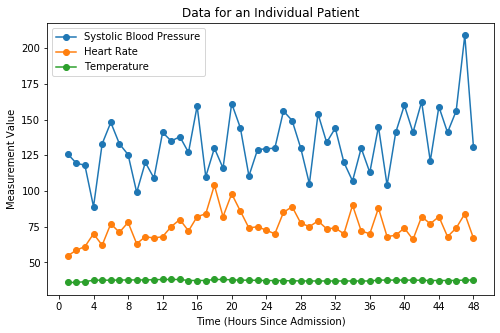

In [20]:
# Plot the processed HR data for hospital admission ID 145834
plt.figure(figsize=(8,5))
plt.plot(time+1, bp, marker="o", label = 'Systolic Blood Pressure')
plt.plot(time+1, hr, marker="o", label = 'Heart Rate')
plt.plot(time+1, temp, marker="o", label = 'Temperature')
plt.xlabel('Time (Hours Since Admission)')
plt.xticks(np.arange(0, 48.1, step=4))
plt.ylabel('Measurement Value')
plt.title('Data for an Individual Patient')
plt.legend()
#plt.savefig('patient.png', bbox_inches='tight')
plt.show()